In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)

import sys
sys.path.insert(0, '../src/')

import kaczmarz
import time

## Generate ill-conditioned matrix, ```eps_cond``` controls condition number 

In [2]:
m = 10000
n = 100
eps_cond = 1e-6
seed = 42
np.random.seed(seed)

A = np.random.randn(m, n)
U, s, V = np.linalg.svd(A, full_matrices=False)
A = U.dot(np.diag(np.maximum(s - np.min(s) + eps_cond, 0))).dot(V)
s = np.linalg.svd(A, compute_uv=False, full_matrices=False)
print("Cond number = {}".format(max(s) / min(s)))
kappa = np.linalg.norm(A, "fro") / min(s)
print("Convergence factor for a consistent linear system = {}".format(kappa))
x_true = np.random.randn(n)

Cond number = 19605065.815627676
Convergence factor for a consistent linear system = 112609049.85223769


### Construct consistent or noisy linear system, control it with a noise level ```sigma```

In [3]:
sigma = 0
b = A.dot(x_true) + sigma * np.random.randn(m)
b = b[:, np.newaxis]
print(A.shape, b.shape)

(10000, 100) (10000, 1)


## Construct preconditioners from sketched matrix

In [4]:
preprocess_time = {
    "$\gamma = 1$": 0,
    "$\gamma = 2$": 0,
    "$\gamma = 3$": 0,
    "$\gamma = 4$": 0,
}
sketch_sizes = [i * n for i in range(1, 5)]
P = {name: [] for name in preprocess_time}

In [5]:
# From some random submatrix
P = {}
for k, i in enumerate(range(1, 5)):
    print("Sketch size = {}".format(n * i))
    st = time.time()
    sketch_idx = np.sort(np.random.choice(np.arange(m), sketch_sizes[k], replace=False))
    Q, R_qr = np.linalg.qr(A[sketch_idx, :])
    P["$\gamma = {}$".format(i)] = np.linalg.inv(R_qr)
    preprocess_time["$\gamma = {}$".format(i)] = time.time() - st

Sketch size = 100
Sketch size = 200
Sketch size = 300
Sketch size = 400


## Defines parameters of the compared methods

In [6]:
max_iter = 300000
tol = 1e-6
x0 = np.zeros(n)
# Maximum number of seconds to run the method
max_time = 1.5
# How frequent the current iterand is stored
log_interval = 10

## Compare preconditioned Kaczmarz method with no preconditioning

In [7]:
test_methods = {"No preconditioning": kaczmarz.UniformKaczmarz(A, b),}
_ = test_methods["No preconditioning"].solve(x0, max_iter, max_time, log_interval)

In [8]:
for name in preprocess_time:
    test_methods[name] = kaczmarz.UniformKaczmarz(A, b, P_right=P[name],
                                                 preprocess_time=preprocess_time[name])

In [9]:
for name in test_methods:
    print(name)
    _ = test_methods[name].solve(x0, max_iter, max_time, log_interval)

No preconditioning
$\gamma = 1$
$\gamma = 2$
$\gamma = 3$
$\gamma = 4$


## Plots
### Relative error vs. number of iterations

$\gamma = 1$
$\gamma = 2$
$\gamma = 3$
$\gamma = 4$


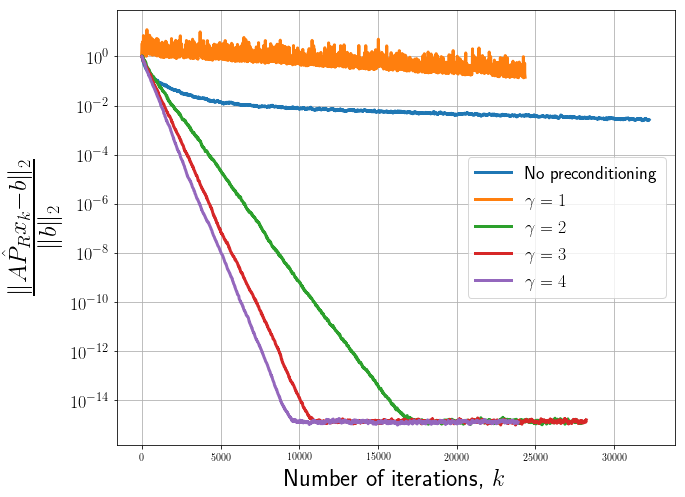

In [10]:
plt.figure(figsize=(10, 8))

for i, name in enumerate(test_methods):
    PR = test_methods[name]._P_right
    start_prec = test_methods[name]._start_prec
    y = []
    cur_time = [t for j, t in enumerate(test_methods[name].get_time()) if j == 0 or j % log_interval == 0] + [test_methods[name].get_time()[-1]]
    if PR is not None:
        print(name)
        if name != "Incremental":
            for j, x in enumerate(test_methods[name].get_convergence()):
                if cur_time[j] - cur_time[0] > start_prec:
    #                 print(j)
                    y.append(np.linalg.norm(A.dot(PR.dot(x)) - b) / np.linalg.norm(b))
                else:
                    y.append(np.linalg.norm(A.dot(x) - b) / np.linalg.norm(b))
    else:
        y = [np.linalg.norm(A.dot(x) - b) / np.linalg.norm(b) 
                  for j, x in enumerate(test_methods[name].get_convergence())]
    x = [j * log_interval for j in range(len(test_methods[name].get_convergence()))]
    plt.semilogy(x, y,
                 label=name, 
                 linewidth=3, 
                 markersize=10)
plt.ylabel(r"$\frac{\|A\hat{P}_Rx_k - b\|_2}{\|b\|_2}$", fontsize=36)
plt.xlabel(r"Number of iterations, $k$", fontsize=24)
plt.legend(fontsize=18)
plt.grid(True)
_ = plt.yticks(fontsize=18)

### Relative error vs. running time + time to construct preconditioners

No preconditioning
$\gamma = 1$
$\gamma = 2$
$\gamma = 3$
$\gamma = 4$


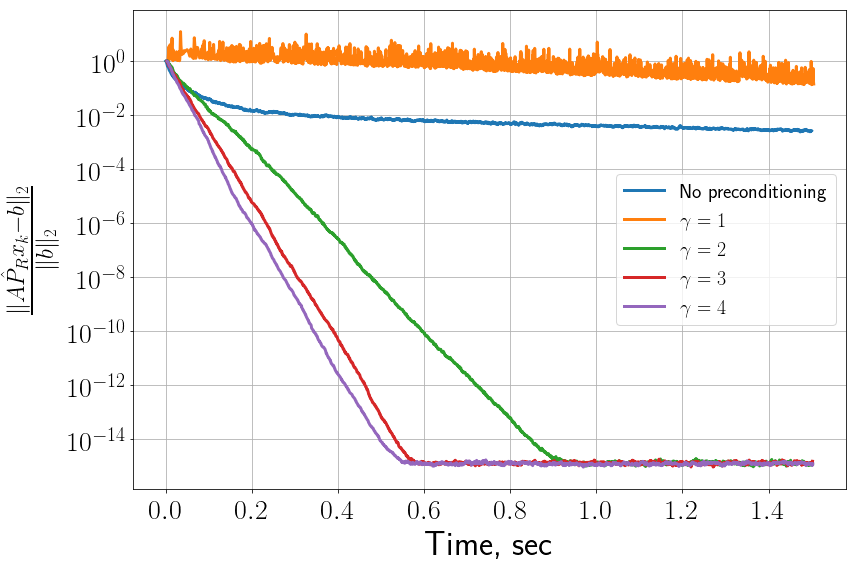

In [11]:
plt.figure(figsize=(12, 8))
markers = ["o", "*", "d", "s", "."]
for i, name in enumerate(test_methods):
    print(name)
    PR = test_methods[name]._P_right
    x_range = [t for j, t in enumerate(test_methods[name].get_time()) if j == 0 or (j+1) % log_interval == 0] + [test_methods[name].get_time()[-1]]
    y = []
    start_prec = test_methods[name]._start_prec
    if PR is not None:
        if name != "Incremental":
            for j, x in enumerate(test_methods[name].get_convergence()):
                if x_range[j] - x_range[0] > start_prec:
                    y.append(np.linalg.norm(A.dot(PR.dot(x)) - b) / np.linalg.norm(b))
                else:
                    y.append(np.linalg.norm(A.dot(x) - b) / np.linalg.norm(b))
        else:
            for i, x in enumerate(test_methods[name].get_convergence()):
                if log_interval * i <= m:
                    y.append(np.linalg.norm(A @ x - b) / np.linalg.norm(b))
                else:
                    y.append(np.linalg.norm(A @ (PR @ x) - b) / np.linalg.norm(b))
    else:
        y = [np.linalg.norm(A.dot(x) - b) / np.linalg.norm(b) 
                  for j, x in enumerate(test_methods[name].get_convergence())]
    plt.semilogy(x_range[:len(y)], y,
                 label=name, 
                 linewidth=3, 
                )
plt.ylabel(r"$\frac{\|A\hat{P}_Rx_k - b\|_2}{\|b\|_2}$", fontsize=34)
plt.xlabel(r"Time, sec", fontsize=34)
plt.legend(fontsize=20)
_ = plt.yticks(fontsize=28)
_ = plt.xticks(fontsize=28)
plt.grid(True)
plt.tight_layout()